# Statistical Methods in AI (CSE/ECE 471) - Spring-2020
#  Assignment-1 / **Q2** / Topic: k Nearest Neighbours
# Submitted By: VENUGOPAL REDDY MEKA
# Roll No: 2019900065

In [1]:
# Load the required imports
import matplotlib.pyplot as plt
import seaborn as sns

# use matplotlib inline for Jupyter notebook
%matplotlib inline

## Load the class KNNClassifier

In [2]:
"""
Statistical Methods in AI (CSE/ECE 471)
Spring-2020
Assignment-1
Q2
Topic: K-Nearest Neighbours
Submitted By: VENUGOPAL REDDY MEKA
Roll No: 2019900065
"""
import pandas as pd
import numpy as np
import logging.config
from collections import Counter
import time
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

logging_config = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'standard': {
            'format': '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
            'datefmt': "%Y-%m-%d %H:%M:%S"
        }
    },
    'handlers': {
        'console': {
            'level': 'DEBUG',
            'formatter': 'standard',
            'class': 'logging.StreamHandler',
            'stream': 'ext://sys.stdout',
        }
    },
    'loggers': {
        '': {
            'handlers': ['console'],
            'level': 'INFO'
        },
    }
}

logging.config.dictConfig(logging_config)


class KNNClassifier:
    """
    KNNClassifier
    """

    def __init__(self, k=5):
        """
        Init
        """
        self.logger = logging.getLogger(__name__)

        if k > 0:
            self.k = int(k)
        else:
            self.logger.warning("Number of neighbours k to be considered for kNN should be > 0. \
                                 Using the default value - 3")
            self.k = 5

        self.headers = ["TARGET",
                        "cap-shape",
                        "cap-surface",
                        "cap-color",
                        "bruises?",
                        "odor",
                        "gill-attachment",
                        "gill-spacing",
                        "gill-size",
                        "gill-color",
                        "stalk-shape",
                        "stalk-root",
                        "stalk-surface-above-ring",
                        "stalk-surface-below-ring",
                        "stalk-color-above-ring",
                        "stalk-color-below-ring",
                        "veil-type",
                        "veil-color",
                        "ring-number",
                        "ring-type",
                        "spore-print-color",
                        "population",
                        "habitat"]

        self.logger.info(f"List of data columns: \n {self.headers}")

        # for caching the train data
        self.df = None
        self.X = None
        self.y = None

        self.most_freq_val = None

    def train(self, train_csv):
        """
        Creates train-validation data split and computes the optimal K value
        :param train_csv:
        :return: None
        """
        try:
            if not train_csv:
                raise ValueError("Input train data csv cannot be None")

            # load the csv file
            self.logger.info("Loading the train data into dataframe")
            self.df = pd.read_csv(train_csv, header=None, names=self.headers)

            # drop rows with missing values
            df_features, df_target = self.prepare_data(self.df)

            # Transform to numpy arrays
            self.X = np.array(df_features)
            self.y = np.array(df_target[df_target.columns[0]])

        except Exception as err:
            self.logger.error("Error occurred while updating the training data ", str(err))

    def predict(self, test_csv):
        """
        Predicts the hand written digits from the 784 dimensional vector's of the test data
        :param test_csv:
        :return: list of predicted digits
        :rtype: List
        """
        try:
            if not test_csv:
                raise ValueError("Input test data csv cannot be None")

            # load the csv file
            self.logger.info("Loading the test data into dataframe")
            df = pd.read_csv(test_csv, header=None, names=self.headers[1:])

            # Scale the features using min max method
            df_features, df_target = self.prepare_data(df)

            # Transform to numpy arrays
            X_test = np.array(df_features)

            return self.predict_with_k(X_test=X_test)

        except Exception as err:
            self.logger.error("Error occurred while doing prediction ", str(err))

    def prepare_data(self, df):
        """
        Prepare the data for training
        :param df:
        :return:
        """
        self.logger.info("Preparing the data")
        self.logger.info("Dropping the rows with missing values - NaN")
        df.dropna(inplace=True)

        missing_value_count = df['stalk-root'][df['stalk-root'] == '?'].shape[0]
        self.logger.info(f"Number of missing values in the column 'stalk-root': {missing_value_count}")

        if missing_value_count > 0:
            if not self.most_freq_val:
                val_counts = df['stalk-root'].value_counts()
                most_freq_val = None
                for index in val_counts.index:
                    if index != '?':
                        most_freq_val = index
                        break
                self.most_freq_val = most_freq_val
            self.logger.info(f"Replacing the value for stalk-root column "
                             f"value = '?' with most frequent value: {self.most_freq_val}")
            df['stalk-root'][df['stalk-root'] == '?'] = self.most_freq_val

        self.logger.info(f"\n {df.head()}")

        if 'TARGET' in df.columns:
            df_features = df.drop(columns=['TARGET'], axis=1)
            self.logger.info(f"\n {df_features.head()}")
            df_target = df[['TARGET']]
        else:
            df_features = df
            df_target = None

        for column in df_features.columns:
            df_features = self.encode_and_bind(df_features, column)
            self.logger.info(f"\n {df_features.head()}")

        return df_features, df_target

    def encode_and_bind(self, df, column):
        """
        Split the categorical columns to numerical columns
        :param df:
        :param column:
        :return:
        """
        df_dummy = pd.get_dummies(df[[column]])
        df_dummy = self.add_missing_dummy_columns(df_dummy, column)
        res = pd.concat([df, df_dummy], axis=1)
        res = res.drop([column], axis=1)
        return res

    def add_missing_dummy_columns(self, df_dummy, column):
        """
        Adds the missing dummy columns
        :param df_dummy:
        :return:
        """
        missing_dummy_columns = self.get_missing_dummy_columns(list(df_dummy.columns), column)
        for missing_dummy_column in missing_dummy_columns:
            df_dummy[missing_dummy_column] = 0

        return df_dummy

    def get_missing_dummy_columns(self, dummy_columns, column):
        """
        Returns the missing dummy columns
        :param dummy_columns:
        :param column:
        :return:
        """
        expected_dummy_columns = self.get_expected_dummy_columns(column)
        missing_dummy_columns = list()
        for expected_dummy_column in expected_dummy_columns:
            if expected_dummy_column not in dummy_columns:
                missing_dummy_columns.append(expected_dummy_column)

        return missing_dummy_columns

    @staticmethod
    def get_expected_dummy_columns(column):
        """
        Returns the list of dummy columns (created from data description text)
        :param column:
        :return:
        """
        expected_dummy_columns = []
        if column == 'cap-shape':
            expected_dummy_columns = ['cap-shape_b', 'cap-shape_c', 'cap-shape_f',
                                      'cap-shape_k', 'cap-shape_s', 'cap-shape_x']
        elif column == 'cap-surface':
            expected_dummy_columns = ['cap-surface_f', 'cap-surface_g', 'cap-surface_s', 'cap-surface_y']

        elif column == 'cap-color':
            expected_dummy_columns = ['cap-color_b', 'cap-color_c', 'cap-color_e', 'cap-color_g',
                                      'cap-color_n', 'cap-color_p', 'cap-color_r', 'cap-color_u',
                                      'cap-color_w', 'cap-color_y']

        elif column == 'bruises?':
            expected_dummy_columns = ['bruises?_f', 'bruises?_t']

        elif column == 'odor':
            expected_dummy_columns = ['odor_a', 'odor_c', 'odor_f', 'odor_l',
                                      'odor_m', 'odor_n', 'odor_p', 'odor_s', 'odor_y']

        elif column == 'gill-attachment':
            expected_dummy_columns = ['gill-attachment_a', 'gill-attachment_d', 'gill-attachment_f',
                                      'gill-attachment_n']

        elif column == 'gill-spacing':
            expected_dummy_columns = ['gill-spacing_c', 'gill-spacing_w', 'gill-spacing_d']

        elif column == 'gill-size':
            expected_dummy_columns = ['gill-size_b', 'gill-size_n']

        elif column == 'gill-color':
            expected_dummy_columns = ['gill-color_b', 'gill-color_e', 'gill-color_g', 'gill-color_h',
                                      'gill-color_k', 'gill-color_n', 'gill-color_o', 'gill-color_p',
                                      'gill-color_r', 'gill-color_u', 'gill-color_w', 'gill-color_y']

        elif column == 'stalk-shape':
            expected_dummy_columns = ['stalk-shape_e', 'stalk-shape_t']

        elif column == 'stalk-root':
            expected_dummy_columns = ['stalk-root_u', 'stalk-root_b', 'stalk-root_c',
                                      'stalk-root_e', 'stalk-root_r', 'stalk-root_z']

        elif column == 'stalk-surface-above-ring':
            expected_dummy_columns = ['stalk-surface-above-ring_f', 'stalk-surface-above-ring_k',
                                      'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y']

        elif column == 'stalk-surface-below-ring':
            expected_dummy_columns = ['stalk-surface-below-ring_f', 'stalk-surface-below-ring_k',
                                      'stalk-surface-below-ring_s', 'stalk-surface-below-ring_y']

        elif column == 'stalk-color-above-ring':
            expected_dummy_columns = ['stalk-color-above-ring_b', 'stalk-color-above-ring_c',
                                      'stalk-color-above-ring_e', 'stalk-color-above-ring_g',
                                      'stalk-color-above-ring_n', 'stalk-color-above-ring_o',
                                      'stalk-color-above-ring_p', 'stalk-color-above-ring_w',
                                      'stalk-color-above-ring_y']

        elif column == 'stalk-color-below-ring':
            expected_dummy_columns = ['stalk-color-below-ring_b', 'stalk-color-below-ring_c',
                                      'stalk-color-below-ring_e', 'stalk-color-below-ring_g',
                                      'stalk-color-below-ring_n', 'stalk-color-below-ring_o',
                                      'stalk-color-below-ring_p', 'stalk-color-below-ring_w',
                                      'stalk-color-below-ring_y']

        elif column == 'veil-type':
            expected_dummy_columns = ['veil-type_p', 'veil-type_u']

        elif column == 'veil-color':
            expected_dummy_columns = ['veil-color_n', 'veil-color_o', 'veil-color_w', 'veil-color_y']

        elif column == 'ring-number':
            expected_dummy_columns = ['ring-number_n', 'ring-number_o', 'ring-number_t']

        elif column == 'ring-type':
            expected_dummy_columns = ['ring-type_e', 'ring-type_f', 'ring-type_l',
                                      'ring-type_n', 'ring-type_p', 'ring-type_c', 'ring-type_s', 'ring-type_z']

        elif column == 'spore-print-color':
            expected_dummy_columns = ['spore-print-color_b', 'spore-print-color_h', 'spore-print-color_k',
                                      'spore-print-color_n', 'spore-print-color_o', 'spore-print-color_r',
                                      'spore-print-color_u', 'spore-print-color_w', 'spore-print-color_y']
        elif column == 'population':
            expected_dummy_columns = ['population_a', 'population_c', 'population_n', 'population_s',
                                      'population_v', 'population_y']

        elif column == 'habitat':
            expected_dummy_columns = ['habitat_d', 'habitat_g', 'habitat_l', 'habitat_m',
                                      'habitat_p', 'habitat_u', 'habitat_w']

        return expected_dummy_columns

    def get_results(self, y_train, y_validate, distances_array, k):
        """

        :param y_train:
        :param y_validate:
        :param distances_array:
        :param k:
        :return:
        """
        self.logger.info(f"Processing for k value : {k}")
        predicted_digits = list()
        sample_size = y_validate.shape[0]
        for idx in range(0, sample_size):
            distances = distances_array[idx][0:k]
            nearest_neighbours = list()
            for index in distances:
                nearest_neighbours.append(y_train[index])

            predicted_digit = Counter(nearest_neighbours).most_common(1)
            predicted_digits.append(predicted_digit[0][0])

        accuracy = self.get_accuracy(y_validate, np.array(predicted_digits))
        self.logger.info(f"Accuracy for k value : {k} - {accuracy}")

        return predicted_digits, accuracy

    def get_distances(self, X_train, X_validate, metric):
        """
        Returns the list of distances between each validate and train vectors
        :param X_train:
        :param X_validate:
        :param metric:
        :return:
        """
        self.logger.info(f"Computing {metric} distances")
        start_time = time.time()
        distances_array = list()
        for point in X_validate:
            if metric == 'euclidean':
                euc_distance = self.get_euclidean_distance(X=X_train, point=point)
                distances = np.argsort(euc_distance)
            elif metric == 'manhattan':
                manh_distance = self.get_manhattan_distance(X=X_train, point=point)
                distances = np.argsort(manh_distance)
            else:
                raise ValueError("Undefined Metric")
            distances_array.append(distances)

        self.logger.info(f"Time taken for get_distances (metric: {metric}) (in seconds): {time.time() - start_time}")

        return distances_array

    def train_validation_split(self, df, validation_size=0.25):
        """
        Split the data into train, validation using the validation_size
        :param df
        :param validation_size:
        :return: X_train, y_train, X_validate, y_validate
        """
        self.logger.info(f"Splitting the train data to train, validation sets with validation_size: {validation_size}")
        # Extract features and target data in a seperate dataframes
        # drop rows with missing values
        df_features, df_target = self.prepare_data(df)

        # Transform to numpy arrays
        self.X = np.array(df_features)
        self.y = np.array(df_target[df_target.columns[0]])

        # Transform to numpy arrays
        X = np.array(df_features)
        y = np.array(df_target[df_target.columns[0]])
        # split and capture train, validation indexes
        indices = np.random.permutation(X.shape[0])
        n_train_indices = int(X.shape[0] * (1.0 - validation_size))
        training_idx, validate_idx = indices[:n_train_indices], indices[n_train_indices:]

        X_train, X_validate = X[training_idx, :], X[validate_idx, :]
        y_train, y_validate = y[training_idx], y[validate_idx]

        return X_train, y_train, X_validate, y_validate

    @staticmethod
    def get_euclidean_distance(X, point):
        return np.sqrt(np.sum((X - point) ** 2, axis=1))

    @staticmethod
    def get_manhattan_distance(X, point):
        return np.sum(np.abs(X - point), axis=1)

    @staticmethod
    def get_accuracy(actual, predicted):
        """
        Returns accuracy in percentage from the actual and predicted numpy arrays
        :param actual:
        :param predicted:
        :return:
        """
        return (actual == predicted).mean() * 100

    def confusion_matrix(self, y_actual, y_pred, labels=None):
        """

        :param y_actual:
        :param y_pred:
        :param labels:
        :return:
        """
        cm = confusion_matrix(y_actual, y_pred, labels)
        self.logger.info(f'Confusion matrix: \n {cm}')
        return cm

    def multilabel_confusion_matrix(self, y_actual, y_pred, labels=None):
        """

        :param y_actual:
        :param y_pred:
        :param labels:
        :return:
        """
        mcm = multilabel_confusion_matrix(y_true=y_actual, y_pred=y_pred, labels=labels)
        self.logger.info(f'Multilabel confusion matrix: \n {mcm}')
        return mcm

    def classification_report(self, y_actual, y_pred, labels=None):
        """

        :param y_actual:
        :param y_pred:
        :param labels:
        :return:
        """
        cl_report = classification_report(y_true=y_actual, y_pred=y_pred, labels=labels, output_dict=True)
        df_report = pd.DataFrame(cl_report).transpose()
        self.logger.info(f'Classification Report: \n {df_report}')
        f1_scores = list()
        for label in labels:
            f1_scores.append(cl_report[str(label)]["f1-score"])

        f1_score_mean = cl_report["macro avg"]["f1-score"]
        f1_score_stddev = np.array(f1_scores).std(axis=0)
        f1_score_median = self.get_median(f1_scores)
        f1_score_abs_dev = self.get_absolute_deviation(f1_scores, f1_score_median)

        self.logger.info(f"Mean F1-Score ± Std Deviation: {f1_score_mean} ± {f1_score_stddev}")
        self.logger.info(f"Median F1-Score ±  Median absolute deviation: {f1_score_median} ± {f1_score_abs_dev}")

        return cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev

    @staticmethod
    def get_median(data):
        """

        :param data:
        :return:
        """
        n = len(data)
        data.sort()

        if n % 2 == 0:
            median1 = data[n // 2]
            median2 = data[n // 2 - 1]
            median = (median1 + median2) / 2
        else:
            median = data[n // 2]

        return median

    @staticmethod
    def get_absolute_deviation(data, value):
        """

        :param data:
        :param value:
        :return:
        """
        sum_val = 0
        # Absolute deviation calculation
        for i in range(len(data)):
            av = np.absolute(data[i] - value)
            sum_val = sum_val + av

        return sum_val / len(data)

    def predict_with_k_range(self,
                             X_train,
                             y_train,
                             X_validate,
                             y_validate,
                             k_min=1,
                             k_max=20,
                             metric='euclidean'):
        """
        Predict within K range
        """
        try:
            if k_min <= 0 or \
                    k_max <= 0 or \
                    k_min > k_max:
                raise ValueError(f"Invalid value for k_min: {k_min}, k_max: {k_max}")

            # Capture all the distances
            distances_array = self.get_distances(X_train, X_validate, metric)

            results = list()
            max_accuracy = -math.inf
            k_best = None
            for k in range(k_min, k_max + 1):
                predicted_digits, accuracy = self.get_results(y_train, y_validate, distances_array, k)
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    k_best = k

                results.append((predicted_digits, accuracy))

            return y_validate, results, k_best

        except Exception as err:
            self.logger.error(f"Error while predicting within k range {k_min} and {k_max}.", str(err))
            raise

    def predict_with_k_range_sklearn(self,
                                     df,
                                     k_min=1,
                                     k_max=20,
                                     metric='euclidean',
                                     validation_size=0.25):
        """
        Predict with sklearn classifier
        """
        try:
            if k_min <= 0 or \
                    k_max <= 0 or \
                    k_min > k_max:
                raise ValueError(f"Invalid value for k_min: {k_min}, k_max: {k_max}")

            df_features, df_target = self.prepare_data(df)
            X = df_features
            y = df_target
            X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=validation_size, random_state=101)
            y_actual = np.array(y_validate['TARGET'])
            results = list()
            k_best = None
            max_accuracy = -math.inf
            for k in range(k_min, k_max + 1):
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
                knn.fit(X_train, np.array(y_train['TARGET']))
                predicted_digits = knn.predict(np.array(X_validate))
                accuracy = accuracy_score(y_actual, predicted_digits) * 100
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    k_best = k

                self.logger.info(f"Accuracy for k value : {k} - {accuracy}")
                results.append((predicted_digits, accuracy))

            return y_actual, results, k_best

        except Exception as err:
            self.logger.error("Error while computing k using sklearn knn classifier.", str(err))
            raise

    def predict_with_k(self, X_test, k=None, metric='euclidean'):
        """
        Predict using k nearest neighbours and given metric
        :param X_test:
        :param k:
        :param metric:
        :return:
        """
        try:
            if not k:
                k = self.k

            # Capture all the distances
            distances_array = self.get_distances(self.X, X_test, metric)

            y_pred = list()
            y_train = self.y
            for idx in range(0, X_test.shape[0]):
                distances = distances_array[idx][0:k]
                nearest_neighbours = list()
                for index in distances:
                    nearest_neighbours.append(y_train[index])

                predicted_label = Counter(nearest_neighbours).most_common(1)
                y_pred.append(predicted_label[0][0])

            return y_pred

        except Exception as err:
            self.logger.error("Error while doing predict_with_k method.", str(err))
            raise


## Experiments

### Load the train data

In [3]:
knn_classifier = KNNClassifier()
df = pd.read_csv('./Datasets/q2/train.csv', header=None, names=knn_classifier.headers)
df.head()

2020-02-01 10:02:42 - INFO - __main__ - List of data columns: 
 ['TARGET', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


,TARGET,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,c,l
1,e,k,s,g,f,n,f,w,b,p,...,s,w,w,p,w,t,p,w,s,g
2,e,b,s,g,f,n,f,w,b,w,...,s,w,w,p,w,t,p,w,s,g
3,e,s,f,g,f,n,f,c,n,n,...,s,w,w,p,w,o,p,n,v,u
4,e,f,f,g,f,n,f,w,b,p,...,f,w,w,p,w,o,e,n,a,g


### Evaluate with k ranging from 1 to 20

In [4]:
k_min = 1
k_max = 20

Split the train data to train validation sets


In [5]:
X_train, y_train, X_validate, y_validate = knn_classifier.train_validation_split(df=df, validation_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)

2020-02-01 10:02:42 - INFO - __main__ - Splitting the train data to train, validation sets with validation_size: 0.25
2020-02-01 10:02:42 - INFO - __main__ - Preparing the data
2020-02-01 10:02:42 - INFO - __main__ - Dropping the rows with missing values - NaN
2020-02-01 10:02:42 - INFO - __main__ - Number of missing values in the column 'stalk-root': 1587
2020-02-01 10:02:42 - INFO - __main__ - Replacing the value for stalk-root column value = '?' with most frequent value: b
2020-02-01 10:02:42 - INFO - __main__ - 
   TARGET cap-shape cap-surface cap-color bruises? odor gill-attachment  \
0      e         k           s         n        f    n               a   
1      e         k           s         g        f    n               f   
2      e         b           s         g        f    n               f   
3      e         s           f         g        f    n               f   
4      e         f           f         g        f    n               f   

  gill-spacing gill-size gill-co

2020-02-01 10:02:42 - INFO - __main__ - 
   odor gill-attachment gill-spacing gill-size gill-color stalk-shape  \
0    n               a            c         b          y           e   
1    n               f            w         b          p           e   
2    n               f            w         b          w           e   
3    n               f            c         n          n           e   
4    n               f            w         b          p           t   

  stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0          b                        s                        s   
1          b                        s                        s   
2          b                        s                        s   
3          e                        s                        s   
4          e                        s                        f   

  stalk-color-above-ring     ...     cap-color_e cap-color_g cap-color_n  \
0                      o     ...               0    

2020-02-01 10:02:43 - INFO - __main__ - 
   stalk-shape stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0           e          b                        s                        s   
1           e          b                        s                        s   
2           e          b                        s                        s   
3           e          e                        s                        s   
4           t          e                        s                        f   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      o                      o         p          n   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type      ...      gill-color_g gill-

[5 rows x 74 columns]
2020-02-01 10:02:43 - INFO - __main__ - 
   stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      o                      o         p          n   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  cap-shape_b  \
0           o         p                 b          c       l            0   
1           t         p                 w          s       g            0   
2           t         p                 w          s       g            1   
3           o         p                 n          v       u            0   
4           o         e                 n          a       g            0   

              ...              stalk-roo

2020-02-01 10:02:43 - INFO - __main__ - 
   veil-color ring-number ring-type spore-print-color population habitat  \
0          n           o         p                 b          c       l   
1          w           t         p                 w          s       g   
2          w           t         p                 w          s       g   
3          w           o         p                 n          v       u   
4          w           o         e                 n          a       g   

   cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k     ...       \
0            0            0            0            1     ...        
1            0            0            0            1     ...        
2            1            0            0            0     ...        
3            0            0            0            0     ...        
4            0            0            1            0     ...        

   stalk-color-below-ring_c  stalk-color-below-ring_e  \
0                         0  

2020-02-01 10:02:43 - INFO - __main__ - 
   population habitat  cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  \
0          c       l            0            0            0            1   
1          s       g            0            0            0            1   
2          s       g            1            0            0            0   
3          v       u            0            0            0            0   
4          a       g            0            0            1            0   

   cap-shape_s  cap-shape_x  cap-surface_f  cap-surface_g  \
0            0            0              0              0   
1            0            0              0              0   
2            0            0              0              0   
3            1            0              1              0   
4            0            0              1              0   

          ...           ring-type_z  spore-print-color_b  spore-print-color_h  \
0         ...                     0                  

### Perform evaluation with metric = 'EUCLIDEAN'

In [6]:
y_validate, results, k_best = knn_classifier.predict_with_k_range(X_train=X_train,
                                                                  y_train=y_train,
                                                                  X_validate=X_validate,
                                                                  y_validate=y_validate,
                                                                  k_min=1,
                                                                  k_max=20,
                                                                  metric='euclidean')

2020-02-01 10:02:43 - INFO - __main__ - Computing euclidean distances
2020-02-01 10:02:48 - INFO - __main__ - Time taken for get_distances (metric: euclidean) (in seconds): 4.7387213706970215
2020-02-01 10:02:48 - INFO - __main__ - Processing for k value : 1
2020-02-01 10:02:48 - INFO - __main__ - Accuracy for k value : 1 - 100.0
2020-02-01 10:02:48 - INFO - __main__ - Processing for k value : 2
2020-02-01 10:02:48 - INFO - __main__ - Accuracy for k value : 2 - 100.0
2020-02-01 10:02:48 - INFO - __main__ - Processing for k value : 3
2020-02-01 10:02:48 - INFO - __main__ - Accuracy for k value : 3 - 100.0
2020-02-01 10:02:48 - INFO - __main__ - Processing for k value : 4
2020-02-01 10:02:48 - INFO - __main__ - Accuracy for k value : 4 - 100.0
2020-02-01 10:02:48 - INFO - __main__ - Processing for k value : 5
2020-02-01 10:02:48 - INFO - __main__ - Accuracy for k value : 5 - 100.0
2020-02-01 10:02:48 - INFO - __main__ - Processing for k value : 6
2020-02-01 10:02:48 - INFO - __main__ - A

In [7]:
accuracy_metrics = list()
f1_scores_mean = list()
for k in range(0, k_max):
    accuracy_metrics.append(results[k][1])
    print("#############################################################################################")
    cm = knn_classifier.confusion_matrix(y_validate, results[k][0], labels=['e', 'p'])
    mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k][0], labels=['e', 'p'])
    cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
    knn_classifier.classification_report(y_validate, results[k][0], labels=['e', 'p'])
    f1_scores_mean.append(f1_score_mean)

print("K value with highest accuracy for metric Euclidean: {k_best}")

#############################################################################################
2020-02-01 10:02:48 - INFO - __main__ - Confusion matrix: 
 [[412   0]
 [  0 712]]
2020-02-01 10:02:48 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  0 412]]

 [[412   0]
  [  0 712]]]
2020-02-01 10:02:48 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    412.0
p                  1.0        1.0     1.0    712.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:02:48 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:48 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0
#############################################################################################
2020-02-01 10:02:48 - INFO - __main__ - Confusion matrix: 

weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:02:48 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:48 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0
#############################################################################################
2020-02-01 10:02:48 - INFO - __main__ - Confusion matrix: 
 [[412   0]
 [  0 712]]
2020-02-01 10:02:48 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  0 412]]

 [[412   0]
  [  0 712]]]
2020-02-01 10:02:48 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    412.0
p                  1.0        1.0     1.0    712.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:02:48 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:48 

2020-02-01 10:02:49 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9990415893926796 ± 0.0002566562213553447
2020-02-01 10:02:49 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9990415893926796 ± 0.0002566562213553447
#############################################################################################
2020-02-01 10:02:49 - INFO - __main__ - Confusion matrix: 
 [[411   1]
 [  0 712]]
2020-02-01 10:02:49 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  1 411]]

 [[411   1]
  [  0 712]]]
2020-02-01 10:02:49 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall     support
e             0.998785   1.000000  0.997573   412.00000
p             0.999298   0.998597  1.000000   712.00000
accuracy      0.999110   0.999110  0.999110     0.99911
macro avg     0.999042   0.999299  0.998786  1124.00000
weighted avg  0.999110   0.999112  0.999110  1124.00000
2020-02-01 10:02:49 - INFO - __main__ - Mean F1-Score ± 

#### Accuracy vs K (Metric: Euclidean)

Text(0,0.5,'Accuarcy')

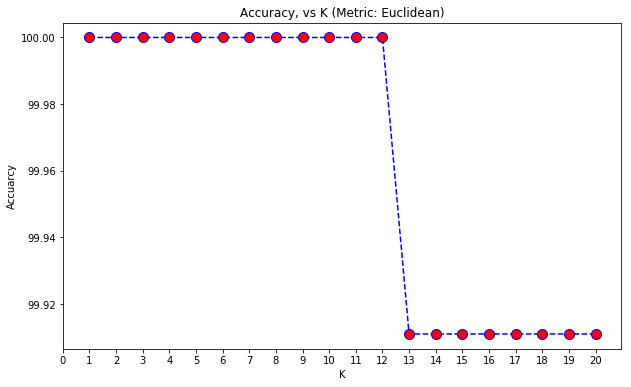

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), accuracy_metrics, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Accuracy, vs K (Metric: Euclidean)")
plt.xlabel("K")
plt.ylabel("Accuarcy")

#### Mean F1-Score vs K (Metric: Euclidean) 

Text(0,0.5,'Mean F1-Score')

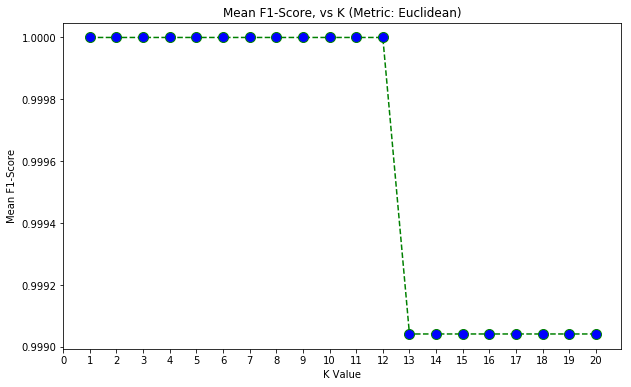

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), f1_scores_mean, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Mean F1-Score, vs K (Metric: Euclidean)")
plt.xlabel("K Value")
plt.ylabel("Mean F1-Score")

### Observation for best K Value (Metric: Euclidean)

In [10]:
print(f"K Value: {k_best} with best accuracy (metric: Euclidean): {accuracy_metrics[k_best-1]}")
print("====================================================================")
cm = knn_classifier.confusion_matrix(y_validate, results[k_best-1][0], labels=['e', 'p'])
mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k_best-1][0], labels=['e', 'p'])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(y_validate, results[k_best-1][0], labels=['e', 'p'])

K Value: 1 with best accuracy (metric: Euclidean): 100.0
2020-02-01 10:02:49 - INFO - __main__ - Confusion matrix: 
 [[412   0]
 [  0 712]]
2020-02-01 10:02:49 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  0 412]]

 [[412   0]
  [  0 712]]]
2020-02-01 10:02:49 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    412.0
p                  1.0        1.0     1.0    712.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:02:49 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:49 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0


### Perform evaluation with metric = 'MANHATTAN'

In [11]:
y_validate, results, k_best = knn_classifier.predict_with_k_range(X_train=X_train,
                                                                  y_train=y_train,
                                                                  X_validate=X_validate,
                                                                  y_validate=y_validate,
                                                                  k_min=1,
                                                                  k_max=20,
                                                                  metric='manhattan')

2020-02-01 10:02:49 - INFO - __main__ - Computing manhattan distances
2020-02-01 10:02:54 - INFO - __main__ - Time taken for get_distances (metric: manhattan) (in seconds): 5.3539721965789795
2020-02-01 10:02:54 - INFO - __main__ - Processing for k value : 1
2020-02-01 10:02:54 - INFO - __main__ - Accuracy for k value : 1 - 100.0
2020-02-01 10:02:54 - INFO - __main__ - Processing for k value : 2
2020-02-01 10:02:54 - INFO - __main__ - Accuracy for k value : 2 - 100.0
2020-02-01 10:02:54 - INFO - __main__ - Processing for k value : 3
2020-02-01 10:02:54 - INFO - __main__ - Accuracy for k value : 3 - 100.0
2020-02-01 10:02:54 - INFO - __main__ - Processing for k value : 4
2020-02-01 10:02:54 - INFO - __main__ - Accuracy for k value : 4 - 100.0
2020-02-01 10:02:54 - INFO - __main__ - Processing for k value : 5
2020-02-01 10:02:54 - INFO - __main__ - Accuracy for k value : 5 - 100.0
2020-02-01 10:02:54 - INFO - __main__ - Processing for k value : 6
2020-02-01 10:02:55 - INFO - __main__ - A

In [12]:
accuracy_metrics = list()
f1_scores_mean = list()
for k in range(0, k_max):
    accuracy_metrics.append(results[k][1])
    print("#############################################################################################")
    cm = knn_classifier.confusion_matrix(y_validate, results[k][0], labels=['e', 'p'])
    mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k][0], labels=['e', 'p'])
    cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
    knn_classifier.classification_report(y_validate, results[k][0], labels=['e', 'p'])
    f1_scores_mean.append(f1_score_mean)

print(f"K value with highest accuracy for metric Manhattan: {k_best}")

#############################################################################################
2020-02-01 10:02:55 - INFO - __main__ - Confusion matrix: 
 [[412   0]
 [  0 712]]
2020-02-01 10:02:55 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  0 412]]

 [[412   0]
  [  0 712]]]
2020-02-01 10:02:55 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    412.0
p                  1.0        1.0     1.0    712.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:02:55 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:55 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0
#############################################################################################
2020-02-01 10:02:55 - INFO - __main__ - Confusion matrix: 

2020-02-01 10:02:55 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:55 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0
#############################################################################################
2020-02-01 10:02:55 - INFO - __main__ - Confusion matrix: 
 [[412   0]
 [  0 712]]
2020-02-01 10:02:55 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  0 412]]

 [[412   0]
  [  0 712]]]
2020-02-01 10:02:55 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    412.0
p                  1.0        1.0     1.0    712.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:02:55 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:55 - INFO - __main__ - Median F1-Score ±  Median absol

2020-02-01 10:02:56 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9990415893926796 ± 0.0002566562213553447
2020-02-01 10:02:56 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9990415893926796 ± 0.0002566562213553447
#############################################################################################
2020-02-01 10:02:56 - INFO - __main__ - Confusion matrix: 
 [[411   1]
 [  0 712]]
2020-02-01 10:02:56 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  1 411]]

 [[411   1]
  [  0 712]]]
2020-02-01 10:02:56 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall     support
e             0.998785   1.000000  0.997573   412.00000
p             0.999298   0.998597  1.000000   712.00000
accuracy      0.999110   0.999110  0.999110     0.99911
macro avg     0.999042   0.999299  0.998786  1124.00000
weighted avg  0.999110   0.999112  0.999110  1124.00000
2020-02-01 10:02:56 - INFO - __main__ - Mean F1-Score ± 

#### Accuracy vs K (Metric: Manhattan)

Text(0,0.5,'Accuarcy')

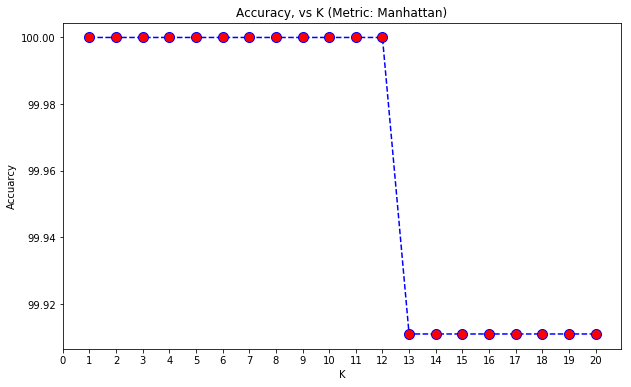

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), accuracy_metrics, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Accuracy, vs K (Metric: Manhattan)")
plt.xlabel("K")
plt.ylabel("Accuarcy")

#### Mean F1 Score vs K (Manhattan)

Text(0,0.5,'Mean F1-Score')

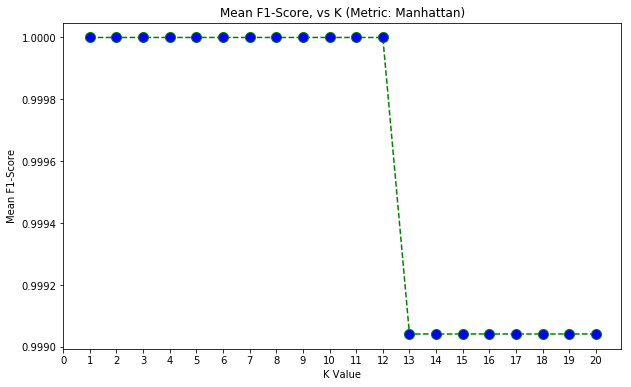

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), f1_scores_mean, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Mean F1-Score, vs K (Metric: Manhattan)")
plt.xlabel("K Value")
plt.ylabel("Mean F1-Score")

### Observations for best K value (Metric: Manhattan Distance)

In [15]:
print(f"K Value: {k_best} with best accuracy (metric: Manhattan): {accuracy_metrics[k_best-1]}")
print("====================================================================")
cm = knn_classifier.confusion_matrix(y_validate, results[k_best-1][0], labels=['e', 'p'])
mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k_best-1][0], labels=['e', 'p'])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(y_validate, results[k_best-1][0], labels=['e', 'p'])

K Value: 1 with best accuracy (metric: Manhattan): 100.0
2020-02-01 10:02:56 - INFO - __main__ - Confusion matrix: 
 [[412   0]
 [  0 712]]
2020-02-01 10:02:56 - INFO - __main__ - Multilabel confusion matrix: 
 [[[712   0]
  [  0 412]]

 [[412   0]
  [  0 712]]]
2020-02-01 10:02:57 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    412.0
p                  1.0        1.0     1.0    712.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:02:57 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:02:57 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0


### Perform evaluation using sklearn KNeighborsClassifier

In [16]:
y_validate, results, k_best = knn_classifier.predict_with_k_range_sklearn(df=df,                                                                 
                                                                          k_min=1,
                                                                          k_max=20,
                                                                          metric='euclidean',
                                                                          validation_size=0.25)

2020-02-01 10:02:57 - INFO - __main__ - Preparing the data
2020-02-01 10:02:57 - INFO - __main__ - Dropping the rows with missing values - NaN
2020-02-01 10:02:57 - INFO - __main__ - Number of missing values in the column 'stalk-root': 0
2020-02-01 10:02:57 - INFO - __main__ - 
   TARGET cap-shape cap-surface cap-color bruises? odor gill-attachment  \
0      e         k           s         n        f    n               a   
1      e         k           s         g        f    n               f   
2      e         b           s         g        f    n               f   
3      e         s           f         g        f    n               f   
4      e         f           f         g        f    n               f   

  gill-spacing gill-size gill-color   ...   stalk-surface-below-ring  \
0            c         b          y   ...                          s   
1            w         b          p   ...                          s   
2            w         b          w   ...                  

2020-02-01 10:02:57 - INFO - __main__ - 
   odor gill-attachment gill-spacing gill-size gill-color stalk-shape  \
0    n               a            c         b          y           e   
1    n               f            w         b          p           e   
2    n               f            w         b          w           e   
3    n               f            c         n          n           e   
4    n               f            w         b          p           t   

  stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0          b                        s                        s   
1          b                        s                        s   
2          b                        s                        s   
3          e                        s                        s   
4          e                        s                        f   

  stalk-color-above-ring     ...     cap-color_e cap-color_g cap-color_n  \
0                      o     ...               0    

2020-02-01 10:02:57 - INFO - __main__ - 
   stalk-shape stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0           e          b                        s                        s   
1           e          b                        s                        s   
2           e          b                        s                        s   
3           e          e                        s                        s   
4           t          e                        s                        f   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      o                      o         p          n   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type      ...      gill-color_g gill-

2020-02-01 10:02:57 - INFO - __main__ - 
   stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      o                      o         p          n   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  cap-shape_b  \
0           o         p                 b          c       l            0   
1           t         p                 w          s       g            0   
2           t         p                 w          s       g            1   
3           o         p                 n          v       u            0   
4           o         e                 n          a       g            0   

              ...              stalk-root_u  stalk-root_z  \
0

2020-02-01 10:02:57 - INFO - __main__ - 
   veil-color ring-number ring-type spore-print-color population habitat  \
0          n           o         p                 b          c       l   
1          w           t         p                 w          s       g   
2          w           t         p                 w          s       g   
3          w           o         p                 n          v       u   
4          w           o         e                 n          a       g   

   cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k     ...       \
0            0            0            0            1     ...        
1            0            0            0            1     ...        
2            1            0            0            0     ...        
3            0            0            0            0     ...        
4            0            0            1            0     ...        

   stalk-color-below-ring_c  stalk-color-below-ring_e  \
0                         0  

2020-02-01 10:02:57 - INFO - __main__ - 
   population habitat  cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  \
0          c       l            0            0            0            1   
1          s       g            0            0            0            1   
2          s       g            1            0            0            0   
3          v       u            0            0            0            0   
4          a       g            0            0            1            0   

   cap-shape_s  cap-shape_x  cap-surface_f  cap-surface_g  \
0            0            0              0              0   
1            0            0              0              0   
2            0            0              0              0   
3            1            0              1              0   
4            0            0              1              0   

          ...           ring-type_z  spore-print-color_b  spore-print-color_h  \
0         ...                     0                  

In [17]:
accuracy_metrics = list()
f1_scores_mean = list()
for k in range(0, k_max):
    accuracy_metrics.append(results[k][1])
    print("#############################################################################################")
    cm = knn_classifier.confusion_matrix(y_validate, results[k][0], labels=['e', 'p'])
    mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k][0], labels=['e', 'p'])
    cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
    knn_classifier.classification_report(y_validate, results[k][0], labels=['e', 'p'])
    f1_scores_mean.append(f1_score_mean)

print(f"K value with highest accuracy using sklearn: {k_best}")

#############################################################################################
2020-02-01 10:03:26 - INFO - __main__ - Confusion matrix: 
 [[393   0]
 [  0 731]]
2020-02-01 10:03:26 - INFO - __main__ - Multilabel confusion matrix: 
 [[[731   0]
  [  0 393]]

 [[393   0]
  [  0 731]]]
2020-02-01 10:03:26 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    393.0
p                  1.0        1.0     1.0    731.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:03:26 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:03:26 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0
#############################################################################################
2020-02-01 10:03:26 - INFO - __main__ - Confusion matrix: 

weighted avg  0.998222   0.998230  0.998221  1124.000000
2020-02-01 10:03:27 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9980460329601557 ± 0.0005841040261456709
2020-02-01 10:03:27 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9980460329601557 ± 0.0005841040261456709
#############################################################################################
2020-02-01 10:03:27 - INFO - __main__ - Confusion matrix: 
 [[393   0]
 [  2 729]]
2020-02-01 10:03:27 - INFO - __main__ - Multilabel confusion matrix: 
 [[[729   2]
  [  0 393]]

 [[393   0]
  [  2 729]]]
2020-02-01 10:03:27 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall      support
e             0.997462   0.994937  1.000000   393.000000
p             0.998630   1.000000  0.997264   731.000000
accuracy      0.998221   0.998221  0.998221     0.998221
macro avg     0.998046   0.997468  0.998632  1124.000000
weighted avg  0.998222   0.998230  0.998221  1124.

2020-02-01 10:03:27 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall      support
e             0.997462   0.994937  1.000000   393.000000
p             0.998630   1.000000  0.997264   731.000000
accuracy      0.998221   0.998221  0.998221     0.998221
macro avg     0.998046   0.997468  0.998632  1124.000000
weighted avg  0.998222   0.998230  0.998221  1124.000000
2020-02-01 10:03:27 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9980460329601557 ± 0.0005841040261456709
2020-02-01 10:03:27 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9980460329601557 ± 0.0005841040261456709
#############################################################################################
2020-02-01 10:03:27 - INFO - __main__ - Confusion matrix: 
 [[393   0]
 [  2 729]]
2020-02-01 10:03:27 - INFO - __main__ - Multilabel confusion matrix: 
 [[[729   2]
  [  0 393]]

 [[393   0]
  [  2 729]]]
2020-02-01 10:03:27 - INFO - __main__ - Classifica

### Accuracy vs K (sklearn)

Text(0,0.5,'Accuarcy')

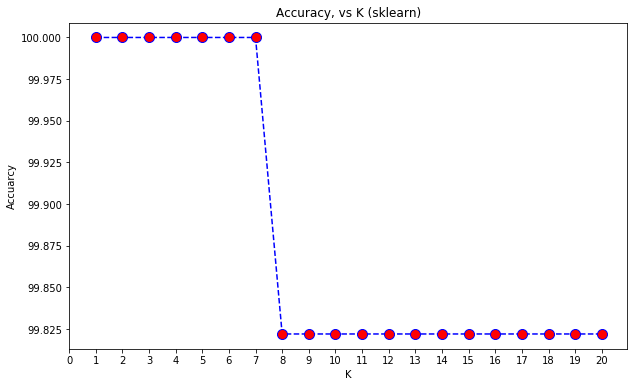

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), accuracy_metrics, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Accuracy, vs K (sklearn)")
plt.xlabel("K")
plt.ylabel("Accuarcy")

### Mean F1 Score vs K (sklearn)

Text(0,0.5,'Mean F1-Score')

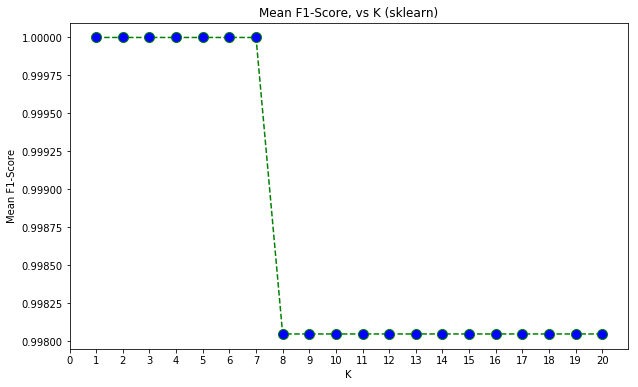

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), f1_scores_mean, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Mean F1-Score, vs K (sklearn)")
plt.xlabel("K")
plt.ylabel("Mean F1-Score")

### Observations for best K value (sklearn)

In [20]:
print(f"K Value: {k_best} with best accuracy: {accuracy_metrics[k_best-1]}")
print("====================================================================")
cm = knn_classifier.confusion_matrix(y_validate, results[k_best-1][0], labels=['e', 'p'])
mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k_best-1][0], labels=['e', 'p'])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(y_validate, results[k_best-1][0], labels=['e', 'p'])

K Value: 1 with best accuracy: 100.0
2020-02-01 10:03:28 - INFO - __main__ - Confusion matrix: 
 [[393   0]
 [  0 731]]
2020-02-01 10:03:28 - INFO - __main__ - Multilabel confusion matrix: 
 [[[731   0]
  [  0 393]]

 [[393   0]
  [  0 731]]]
2020-02-01 10:03:28 - INFO - __main__ - Classification Report: 
               f1-score  precision  recall  support
e                  1.0        1.0     1.0    393.0
p                  1.0        1.0     1.0    731.0
accuracy           1.0        1.0     1.0      1.0
macro avg          1.0        1.0     1.0   1124.0
weighted avg       1.0        1.0     1.0   1124.0
2020-02-01 10:03:28 - INFO - __main__ - Mean F1-Score ± Std Deviation: 1.0 ± 0.0
2020-02-01 10:03:28 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 1.0 ± 0.0


## Final K Value

From the results (custom KNNClassifier, sklearn) the odd K value with highest accuracy is 3.
We use K = 3 to perform prediction on the test data

### Prediction on the test samples

In [ ]:
knn_classifier = KNNClassifier()
knn_classifier.train('./Datasets/q2/train.csv')
predictions = knn_classifier.predict('./Datasets/q2/test.csv')
test_labels = list()
with open("./Datasets/q2/test_labels.csv") as f:
  for line in f:
    test_labels.append(line.strip())
print(f"Accuracy Score: {accuracy_score(test_labels, predictions)}")

print("Predicted Labels")
print(predictions)
print("Test Labels")
print(test_labels)
print("Accuracy Score")
print(accuracy_score(test_labels, predictions))
print("Confusion Matrix")
cm = knn_classifier.confusion_matrix(test_labels, predictions, labels=['e', 'p'])
mcm = knn_classifier.multilabel_confusion_matrix(test_labels, predictions, labels=['e', 'p'])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(test_labels, predictions, labels=['e', 'p'])

2020-02-01 10:03:28 - INFO - __main__ - List of data columns: 
 ['TARGET', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
2020-02-01 10:03:28 - INFO - __main__ - Loading the train data into dataframe
2020-02-01 10:03:28 - INFO - __main__ - Preparing the data
2020-02-01 10:03:28 - INFO - __main__ - Dropping the rows with missing values - NaN
2020-02-01 10:03:28 - INFO - __main__ - Number of missing values in the column 'stalk-root': 1587
2020-02-01 10:03:28 - INFO - __main__ - Replacing the value for stalk-root column value = '?' with most frequent value: b
2020-02-01 10:03:28 - INFO - __main__ - 
   TARGET cap-shape cap-surface cap-color bruises? odor gill-attachment  \
0      

2020-02-01 10:03:28 - INFO - __main__ - 
   odor gill-attachment gill-spacing gill-size gill-color stalk-shape  \
0    n               a            c         b          y           e   
1    n               f            w         b          p           e   
2    n               f            w         b          w           e   
3    n               f            c         n          n           e   
4    n               f            w         b          p           t   

  stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0          b                        s                        s   
1          b                        s                        s   
2          b                        s                        s   
3          e                        s                        s   
4          e                        s                        f   

  stalk-color-above-ring     ...     cap-color_e cap-color_g cap-color_n  \
0                      o     ...               0    

2020-02-01 10:03:28 - INFO - __main__ - 
   stalk-shape stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0           e          b                        s                        s   
1           e          b                        s                        s   
2           e          b                        s                        s   
3           e          e                        s                        s   
4           t          e                        s                        f   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      o                      o         p          n   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type      ...      gill-color_g gill-

2020-02-01 10:03:28 - INFO - __main__ - 
   stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      o                      o         p          n   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  cap-shape_b  \
0           o         p                 b          c       l            0   
1           t         p                 w          s       g            0   
2           t         p                 w          s       g            1   
3           o         p                 n          v       u            0   
4           o         e                 n          a       g            0   

              ...              stalk-root_u  stalk-root_z  \
0

2020-02-01 10:03:28 - INFO - __main__ - 
   veil-color ring-number ring-type spore-print-color population habitat  \
0          n           o         p                 b          c       l   
1          w           t         p                 w          s       g   
2          w           t         p                 w          s       g   
3          w           o         p                 n          v       u   
4          w           o         e                 n          a       g   

   cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k     ...       \
0            0            0            0            1     ...        
1            0            0            0            1     ...        
2            1            0            0            0     ...        
3            0            0            0            0     ...        
4            0            0            1            0     ...        

   stalk-color-below-ring_c  stalk-color-below-ring_e  \
0                         0  

2020-02-01 10:03:28 - INFO - __main__ - 
   population habitat  cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  \
0          c       l            0            0            0            1   
1          s       g            0            0            0            1   
2          s       g            1            0            0            0   
3          v       u            0            0            0            0   
4          a       g            0            0            1            0   

   cap-shape_s  cap-shape_x  cap-surface_f  cap-surface_g  \
0            0            0              0              0   
1            0            0              0              0   
2            0            0              0              0   
3            1            0              1              0   
4            0            0              1              0   

          ...           ring-type_z  spore-print-color_b  spore-print-color_h  \
0         ...                     0                  

2020-02-01 10:03:28 - INFO - __main__ - 
   cap-surface cap-color bruises? odor gill-attachment gill-spacing gill-size  \
0           y         n        t    n               f            c         b   
1           y         y        t    l               f            c         b   
2           y         g        t    n               f            c         b   
3           s         g        f    n               f            w         b   
4           s         y        t    l               f            c         b   

  gill-color stalk-shape stalk-root     ...     ring-type spore-print-color  \
0          w           t          b     ...             p                 n   
1          n           e          c     ...             p                 k   
2          n           t          b     ...             p                 n   
3          n           t          e     ...             e                 k   
4          g           e          c     ...             p                 n   

  

2020-02-01 10:03:29 - INFO - __main__ - 
   gill-spacing gill-size gill-color stalk-shape stalk-root  \
0            c         b          w           t          b   
1            c         b          n           e          c   
2            c         b          n           t          b   
3            w         b          n           t          e   
4            c         b          g           e          c   

  stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
0                        s                        s                      w   
1                        s                        s                      w   
2                        s                        s                      g   
3                        f                        f                      w   
4                        s                        s                      w   

  stalk-color-below-ring veil-type        ...         odor_l odor_m odor_n  \
0                      w         p    

2020-02-01 10:03:29 - INFO - __main__ - 
   stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0          b                        s                        s   
1          c                        s                        s   
2          b                        s                        s   
3          e                        f                        f   
4          c                        s                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      g                      p         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color      ...       gill-color_k  \
0           o         p                 n      ...     

2020-02-01 10:03:29 - INFO - __main__ - 
   stalk-color-below-ring veil-type veil-color ring-number ring-type  \
0                      w         p          w           o         p   
1                      w         p          w           o         p   
2                      p         p          w           o         p   
3                      w         p          w           o         e   
4                      w         p          w           o         p   

  spore-print-color population habitat  cap-shape_b  cap-shape_c  \
0                 n          y       d            0            0   
1                 k          n       g            1            0   
2                 n          y       d            0            0   
3                 k          s       g            0            0   
4                 n          n       g            0            0   

             ...             stalk-surface-below-ring_y  \
0            ...                                      0   
1   

2020-02-01 10:03:29 - INFO - __main__ - 
   ring-type spore-print-color population habitat  cap-shape_b  cap-shape_c  \
0         p                 n          y       d            0            0   
1         p                 k          n       g            1            0   
2         p                 n          y       d            0            0   
3         e                 k          s       g            0            0   
4         p                 n          n       g            0            0   

   cap-shape_f  cap-shape_k  cap-shape_s  cap-shape_x      ...        \
0            0            0            0            1      ...         
1            0            0            0            0      ...         
2            1            0            0            0      ...         
3            1            0            0            0      ...         
4            0            0            0            1      ...         

   stalk-color-below-ring_y  veil-type_p  veil-type_u  v

2020-02-01 10:03:29 - INFO - __main__ - 
    cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0            0            0            0            0            0   
1            1            0            0            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            0            0            0   

   cap-shape_x  cap-surface_f  cap-surface_s  cap-surface_y  cap-surface_g  \
0            1              0              0              1              0   
1            0              0              0              1              0   
2            0              0              0              1              0   
3            0              0              1              0              0   
4            1              0              1              0              0   

     ...      population_s  population_v  population_y  habitat_d  h